In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Load the dataset
data_path = "Soybean.csv"
df = pd.read_csv(data_path)

# Basic dataset info
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (683, 36)

Column names:
['Class', 'date', 'plant.stand', 'precip', 'temp', 'hail', 'crop.hist', 'area.dam', 'sever', 'seed.tmt', 'germ', 'plant.growth', 'leaves', 'leaf.halo', 'leaf.marg', 'leaf.size', 'leaf.shread', 'leaf.malf', 'leaf.mild', 'stem', 'lodging', 'stem.cankers', 'canker.lesion', 'fruiting.bodies', 'ext.decay', 'mycelium', 'int.discolor', 'sclerotia', 'fruit.pods', 'fruit.spots', 'seed', 'mold.growth', 'seed.discolor', 'seed.size', 'shriveling', 'roots']

First few rows:


,Class,date,plant.stand,precip,temp,hail,crop.hist,area.dam,sever,seed.tmt,...,int.discolor,sclerotia,fruit.pods,fruit.spots,seed,mold.growth,seed.discolor,seed.size,shriveling,roots
0,diaporthe-stem-canker,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,diaporthe-stem-canker,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,diaporthe-stem-canker,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,diaporthe-stem-canker,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,diaporthe-stem-canker,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing values:
lodging            121
hail               121
sever              121
seed.tmt           121
germ               112
leaf.mild          108
fruiting.bodies    106
shriveling         106
seed.discolor      106
fruit.spots        106
leaf.shread        100
seed.size           92
mold.growth         92
seed                92
fruit.pods          84
leaf.malf           84
leaf.halo           84
leaf.size           84
leaf.marg           84
sclerotia           38
precip              38
stem.cankers        38
canker.lesion       38
ext.decay           38
mycelium            38
int.discolor        38
plant.stand         36
roots               31
temp                30
stem                16
plant.growth        16
crop.hist           16
date                 1
area.dam             1
leaves               0
Class                0
dtype: int64


In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Assume df is your existing DataFrame
# Example strategy: fill numerical columns with mean
imputer = SimpleImputer(strategy='mean')

# Apply only to numerical columns
df[df.select_dtypes(include=['number']).columns] = imputer.fit_transform(
    df.select_dtypes(include=['number'])
)

# Impute categorical columns with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

df[df.select_dtypes(include=['object', 'category']).columns] = cat_imputer.fit_transform(
    df.select_dtypes(include=['object', 'category'])
)


In [4]:
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing values:
Class              0
date               0
lodging            0
stem.cankers       0
canker.lesion      0
fruiting.bodies    0
ext.decay          0
mycelium           0
int.discolor       0
sclerotia          0
fruit.pods         0
fruit.spots        0
seed               0
mold.growth        0
seed.discolor      0
seed.size          0
shriveling         0
stem               0
leaf.mild          0
leaf.malf          0
sever              0
plant.stand        0
precip             0
temp               0
hail               0
crop.hist          0
area.dam           0
seed.tmt           0
leaf.shread        0
germ               0
plant.growth       0
leaves             0
leaf.halo          0
leaf.marg          0
leaf.size          0
roots              0
dtype: int64


In [5]:

le = LabelEncoder()
# Encode the target column
df['Class'] = le.fit_transform(df['Class'])

df.head()

,Class,date,plant.stand,precip,temp,hail,crop.hist,area.dam,sever,seed.tmt,...,int.discolor,sclerotia,fruit.pods,fruit.spots,seed,mold.growth,seed.discolor,seed.size,shriveling,roots
0,10,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Check the target variable distribution
print("\nTarget variable distribution:")
print(df['Class'].value_counts())


Target variable distribution:
Class
5     92
12    91
1     91
15    88
6     44
2     44
10    20
17    20
14    20
4     20
7     20
3     20
11    20
16    20
18    20
0     16
9     15
8     14
13     8
Name: count, dtype: int64


In [7]:


# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Handle missing values
# For this dataset, we'll use mode for categorical variables
for col in X.columns:
    if X[col].dtype == 'object':
        # Fill categorical missing values with mode
        mode_value = X[col].mode()[0] if not X[col].mode().empty else 'missing'
        X[col].fillna(mode_value, inplace=True)
    else:
        # Fill numerical missing values with median
        X[col].fillna(X[col].median(), inplace=True)

# Store original column names for reference
original_columns = X.columns.tolist()

# Label encode categorical features
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Convert to numpy array
X = X.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1
)

In [8]:
# Fit the model
print("\nTraining the model...")
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training the model...

Model Accuracy: 0.9635

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.82      1.00      0.90        18
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       0.95      1.00      0.97        18
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      0.83      0.91        18
          13       1.00      1.00      1.00         2
          14       1.00      0.50      0.67         4
          15       1.00      1.00      1.00        18
          

In [9]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': original_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
          feature  importance
0            date    0.074859
28    fruit.spots    0.064812
21  canker.lesion    0.064787
14      leaf.size    0.064535
27     fruit.pods    0.052295
12      leaf.halo    0.044910
25   int.discolor    0.044629
13      leaf.marg    0.039030
20   stem.cankers    0.038484
23      ext.decay    0.032665


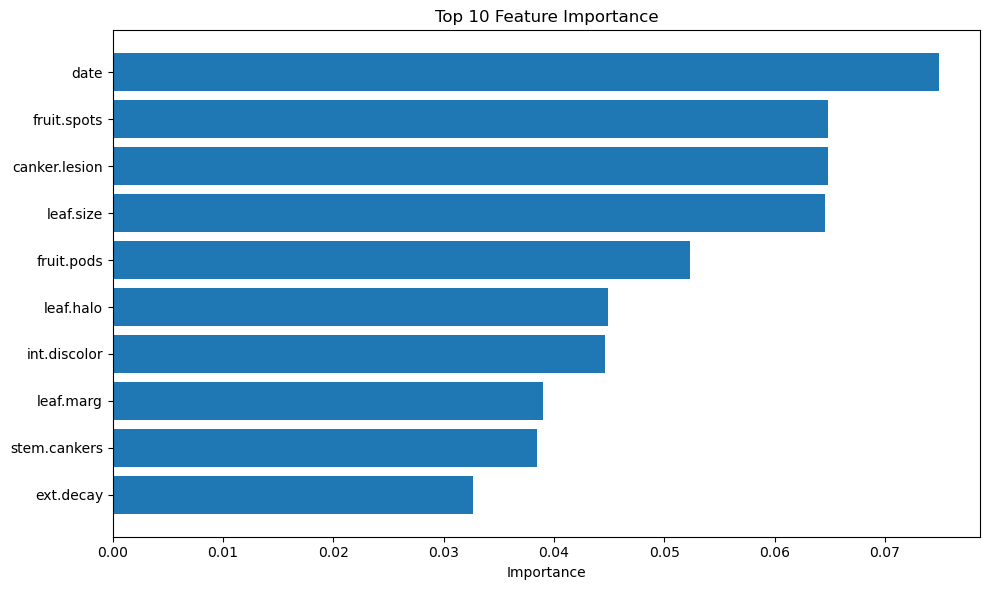

In [10]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

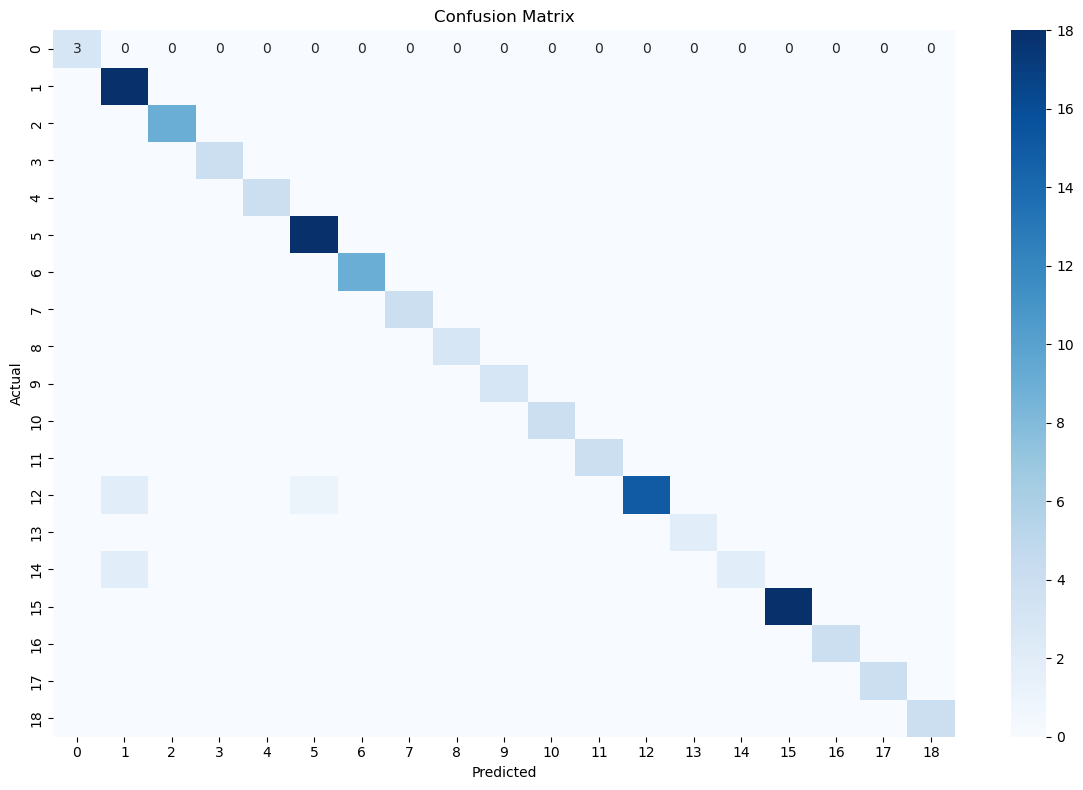

In [11]:
# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [12]:
# Create directory for saving models
os.makedirs('soybean_models', exist_ok=True)

# Save the model and preprocessors
joblib.dump(model, 'soybean_models/soybean_model.pkl')
joblib.dump(scaler, 'soybean_models/scaler.pkl')
joblib.dump(label_encoders, 'soybean_models/label_encoders.pkl')
joblib.dump(original_columns, 'soybean_models/feature_names.pkl')

# Save the unique classes
joblib.dump(model.classes_, 'soybean_models/classes.pkl')

print("\nModel and preprocessors saved successfully!")


Model and preprocessors saved successfully!


In [13]:
# Define prediction function for Streamlit
def predict_soybean_disease(features_dict):
    """
    Predict soybean disease based on input features
    features_dict: dictionary with feature names as keys and values
    """
    # Create a DataFrame with the same structure as training data
    input_df = pd.DataFrame([features_dict])
    
    # Handle missing values
    for col in input_df.columns:
        if input_df[col].isna().any():
            if col in label_encoders:
                input_df[col].fillna('missing', inplace=True)
            else:
                input_df[col].fillna(0, inplace=True)
    
    # Apply label encoding
    for col in input_df.columns:
        if col in label_encoders:
            # Handle unseen labels
            le = label_encoders[col]
            # Get the value
            value = input_df[col].iloc[0]
            if value in le.classes_:
                input_df[col] = le.transform([value])[0]
            else:
                # Assign a default value for unseen labels
                input_df[col] = 0
    
    # Ensure all columns are present
    for col in original_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[original_columns]
    
    # Scale the features
    features_scaled = scaler.transform(input_df.values)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Get probability for each class
    class_probabilities = {cls: prob for cls, prob in zip(model.classes_, probabilities)}
    
    return {
        'prediction': prediction,
        'confidence': max(probabilities),
        'probabilities': class_probabilities
    }

In [14]:
# Test the prediction function
# Example: Create a sample input
sample_features = {col: X_test[0][i] for i, col in enumerate(original_columns)}
result = predict_soybean_disease(sample_features)

print("\nTest Prediction:")
print(f"Predicted Disease: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print("\nProbabilities for all classes:")
for cls, prob in result['probabilities'].items():
    print(f"{cls}: {prob:.4f}")

# Save a sample of the data for reference
df_sample = df.head(10)
df_sample.to_csv('soybean_models/sample_data.csv', index=False)

print("\nAll files saved. Ready for Streamlit deployment!")


Test Prediction:
Predicted Disease: 2
Confidence: 0.8988

Probabilities for all classes:
0: 0.0000
1: 0.0000
2: 0.8988
3: 0.0000
4: 0.0000
5: 0.0090
6: 0.0100
7: 0.0000
8: 0.0000
9: 0.0000
10: 0.0053
11: 0.0000
12: 0.0100
13: 0.0000
14: 0.0000
15: 0.0500
16: 0.0000
17: 0.0169
18: 0.0000

All files saved. Ready for Streamlit deployment!


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            683 non-null    int32  
 1   date             683 non-null    float64
 2   plant.stand      683 non-null    float64
 3   precip           683 non-null    float64
 4   temp             683 non-null    float64
 5   hail             683 non-null    float64
 6   crop.hist        683 non-null    float64
 7   area.dam         683 non-null    float64
 8   sever            683 non-null    float64
 9   seed.tmt         683 non-null    float64
 10  germ             683 non-null    float64
 11  plant.growth     683 non-null    float64
 12  leaves           683 non-null    float64
 13  leaf.halo        683 non-null    float64
 14  leaf.marg        683 non-null    float64
 15  leaf.size        683 non-null    float64
 16  leaf.shread      683 non-null    float64
 17  leaf.malf       

In [16]:
df.head()

,Class,date,plant.stand,precip,temp,hail,crop.hist,area.dam,sever,seed.tmt,...,int.discolor,sclerotia,fruit.pods,fruit.spots,seed,mold.growth,seed.discolor,seed.size,shriveling,roots
0,10,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
import os
os.getcwd()

'C:\\Users\\lenovo\\soyabean'